In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import meta
import datetime
import yfinance as yf
import os

# Notebook Model
This notebook analyzes a random forest whose parameters were optimized for the SNP 500 index. The bot traded for 15 years on all companies that had at least 30 years of data

In [28]:
temp_path = os.path.join('..', 'data_files', 'backtest_data', 'results', 'value_1.022_0.956_0.350.csv')
value = pd.read_csv(temp_path).dropna()
snp_tick = yf.Ticker('^GSPC')
snp = snp_tick.history(start=value['date'].min(), end=value['date'].max(), interval='1d')
snp = snp.reset_index()[['Date', 'Close']]
snp['Date'] = snp['Date'].astype(str)
ffill = snp.set_index('Date').reindex(value.set_index('date').index, method='ffill').reset_index()
bfill = snp.set_index('Date').reindex(value.set_index('date').index, method='bfill').reset_index()
all_filled = pd.merge(ffill, bfill, on='date', how='inner')
all_filled['Close'] = all_filled.apply(lambda x: x['Close_x'] if not pd.isna(x['Close_x']) else x['Close_y'], axis=1)
all_filled = all_filled.drop(columns=(['Close_x', 'Close_y']), axis=1)
all_filled.columns=['Date', 'Close']
comb = pd.merge(all_filled, value, left_on='Date', right_on='date').drop(columns=['date'], axis=1)
comb['Close'] = comb['Close'] / comb.iloc[0, comb.columns.get_loc('Close')] * 100
comb['value'] = comb['value'] / 100000 * 100

In [29]:
value

,date,value
0,2001-10-26,79047.841907
1,2001-11-02,78389.216907
2,2001-11-09,78030.347228
3,2001-11-16,76027.798118
4,2001-11-23,77990.538002
...,...,...
422,2009-11-27,614944.744489
423,2009-12-04,621716.931852
424,2009-12-11,655930.058903
425,2009-12-18,661893.491923


## Compare performance by the datetime format indicator
- ### I.E: Monthly, yearly
The table below indicates performance in a given window. The first table breaks performance down by year. The values in the colored cells indicate the diffrence in percent change of the SNP 500 and the Trading Bot for the given window.

In [30]:

## Returns the value associated with the largest day in the dataframe divided by the value associated
## with the smallest day in the dataframe
def get_window_performance(df, date_col, val_col):
    start = df.loc[df[date_col] == df[date_col].min(), val_col].iloc[0]
    end = df.loc[df[date_col] == df[date_col].max(), val_col].iloc[0]
    return end / start

## Returns a dataframe grouped by the given formatter with a ratio for each group indicating the value
## on the last day for that group divided by the value for the first day of that group
def get_performance_breakdown(day_val_df, formatters=['%Y'], date_col='date', val_col = 'value'):
    day_val_df[date_col] = pd.to_datetime(day_val_df[date_col])
    group_by_cols = []
    for i, formatter in enumerate(formatters):
        day_val_df['Date' + str(i)] = day_val_df[date_col].dt.strftime(formatter)
        group_by_cols.append('Date' + str(i))
    grouped = day_val_df.groupby(group_by_cols).apply(lambda df: get_window_performance(df, date_col, val_col))
    grouped.name = val_col
    return grouped.to_frame()

## Pre-define color ranges for the differences between bot and snp for easy comparison
## Boundaries are defined for one year. Use a scaler for different granularity
def get_colors(col, use_cols=None, scaler = 1):
    ret = col.copy()
    ret[:] = ''
    if (use_cols is not None) and (col.name not in use_cols):
        return ret
    
    neg_bounds = [-0.01, -0.05, -0.1, -0.25, -0.5, -1]
    pos_bounds = [-1 * n for n in neg_bounds]
    opacities = [0.1, 0.2, 0.4, 0.6, 0.75, 1]
    
    for i in range(len(neg_bounds)):
        ret[col <= neg_bounds[i] * scaler] = 'background-color:rgba(255, 0, 0, ' + str(opacities[i]) + ');'
        ret[col >= pos_bounds[i] * scaler] = 'background-color:rgba(0, 255, 0, ' + str(opacities[i]) + ');'
    return ret

## Colors the cells according to the differences using min-max normalization
def style_cells(col, use_cols=None):
    col = col.copy()
    if (use_cols is not None) and (col.name not in use_cols):
        col[:] = ''
        return col
    p_col = col > 0
    n_col = col <= 0
    max_pos = col.max()
    min_pos = col[p_col].min()
    max_neg = col[n_col].max()
    min_neg = col.min()
    col[p_col] = (col[p_col] - min_pos) / (max_pos - min_pos)
    col[n_col] = (col[n_col] - max_neg) / (min_neg - max_neg)
    col[n_col] = col[n_col].apply(lambda x: 'background-color:rgba(255, 0, 0, ' + str(x) + ');')
    col[p_col] = col[p_col].apply(lambda x: 'background-color:rgba(0, 255, 0, ' + str(x) + ');')
    return col

snp_perf = get_performance_breakdown(snp, date_col='Date', val_col='Close').rename(columns={'Close': 'SNP'})
bot_perf = get_performance_breakdown(value).rename(columns={'value': 'BOT'})
together = snp_perf.join(bot_perf)
together['DIFF'] = together['BOT'] - together['SNP']
together.style.apply(get_colors, use_cols=['DIFF'], axis=0)

,SNP,BOT,DIFF
Date0,,,
2001,1.039353,1.073268,0.033914
2002,0.761967,1.151058,0.389092
2003,1.223194,1.531511,0.308317
2004,1.093317,0.995473,-0.097844
2005,1.038442,1.369560,0.331118
2006,1.117828,0.971398,-0.146430
2007,1.036538,1.252883,0.216345
2008,0.624153,1.398016,0.773863
2009,1.208929,2.357465,1.148536


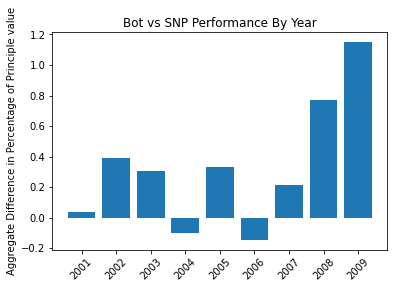

In [31]:
fig, ax = plt.subplots()
ax.bar(together.index.values, together['DIFF'])
ax.set_xticks(np.arange(len(together) ))
ax.set_xticklabels(together.index.values, rotation=45)
ax.set_title('Bot vs SNP Performance By Year')
ax.set_ylabel('Aggregate Difference in Percentage of Principle value')
fig.set_size_inches(6, 4)

In [32]:
snp_perf = get_performance_breakdown(snp, formatters=['%Y', '%m'], date_col='Date', val_col='Close').rename(columns={'Close': 'SNP'})
bot_perf = get_performance_breakdown(value, formatters=['%Y', '%m']).rename(columns={'Close': 'SNP'})
joined = snp_perf.join(bot_perf)
diff = joined['value'] - joined['SNP']
diff = diff.unstack()
diff.columns = [datetime.datetime.strptime(x, '%m').strftime('%B') for x in diff.columns]
diff.style.apply(get_colors, scaler =1/6, axis=0)

,January,February,March,April,May,June,July,August,September,October,November,December
Date0,,,,,,,,,,,,
2001,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.040584,-0.091877,0.063048
2002,-0.026118,-0.126999,-0.023085,0.092753,-0.053166,-0.003539,0.121657,0.085726,0.016108,-0.035686,0.023649,0.077731
2003,-0.161880,0.056524,0.230561,0.013955,-0.029498,0.039045,-0.048784,0.105647,0.051523,0.032930,-0.072354,-0.048115
2004,0.064418,0.069756,0.003996,-0.044694,0.027521,-0.036585,0.035851,-0.065743,0.011966,-0.052943,-0.007963,-0.003386
2005,-0.015531,0.077091,0.001235,0.058500,-0.000102,0.036024,-0.006915,-0.032563,0.071651,0.029071,0.019031,-0.001686
2006,-0.123267,0.030090,0.042827,-0.052079,0.015383,0.068208,0.055993,-0.010422,-0.028086,0.005879,-0.052546,-0.036425
2007,0.004609,0.036431,0.062371,-0.069643,-0.006390,0.033988,0.126508,-0.019810,-0.060822,-0.022684,0.099015,0.050530
2008,-0.045490,-0.057302,0.018922,0.024093,0.136945,0.103072,0.096496,-0.033143,0.367869,-0.050949,0.219795,-0.033076
2009,0.121567,0.015790,0.092807,0.095702,0.077514,0.047487,0.119146,0.030464,-0.137659,0.049710,0.011547,0.099949


In [33]:
## Get the Differences By Month
diff_sum = diff.sum(axis=0)
diff_sum.name = 'Aggregate Difference Between Bot and SNP Performance'
diff_sum.to_frame().style.apply(get_colors)

,Aggregate Difference Between Bot and SNP Performance
January,-0.181692
February,0.101381
March,0.429634
April,0.118588
May,0.168207
June,0.287701
July,0.499951
August,0.060155
September,0.292550
October,-0.004086


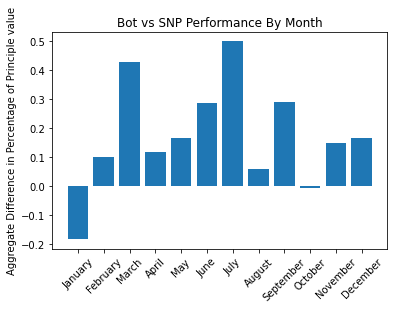

In [34]:
fig, ax = plt.subplots()
ax.bar(diff_sum.index.values, diff_sum)
ax.set_xticks(np.arange(len(diff_sum) ))
ax.set_xticklabels(diff_sum.index.values, rotation=45)
ax.set_title('Bot vs SNP Performance By Month')
ax.set_ylabel('Aggregate Difference in Percentage of Principle value')
fig.set_size_inches(6, 4)

In [35]:
## Dropping duplicates keeps the first value so you can use it to find the first date of each year
years = pd.to_datetime(comb['Date'])
years = years.dt.strftime('%Y').drop_duplicates().to_frame()
years.index.name = 'Index'
years = years.reset_index()

In [36]:
for i, row in comb.iterrows():
    print(row['Date'])

2001-10-26
2001-11-02
2001-11-09
2001-11-16
2001-11-23
2001-11-30
2001-12-07
2001-12-14
2001-12-21
2001-12-28
2002-01-04
2002-01-11
2002-01-18
2002-01-25
2002-02-01
2002-02-08
2002-02-15
2002-02-22
2002-03-01
2002-03-08
2002-03-15
2002-03-22
2002-03-29
2002-04-05
2002-04-12
2002-04-19
2002-04-26
2002-05-03
2002-05-10
2002-05-17
2002-05-24
2002-05-31
2002-06-07
2002-06-14
2002-06-21
2002-06-28
2002-07-05
2002-07-12
2002-07-19
2002-07-26
2002-08-02
2002-08-09
2002-08-16
2002-08-23
2002-08-30
2002-09-06
2002-09-13
2002-09-20
2002-09-27
2002-10-04
2002-10-11
2002-10-18
2002-10-25
2002-11-01
2002-11-08
2002-11-15
2002-11-22
2002-11-29
2002-12-06
2002-12-13
2002-12-20
2002-12-27
2003-01-03
2003-01-10
2003-01-17
2003-01-24
2003-01-31
2003-02-07
2003-02-14
2003-02-21
2003-02-28
2003-03-07
2003-03-14
2003-03-21
2003-03-28
2003-04-04
2003-04-11
2003-04-18
2003-04-25
2003-05-02
2003-05-09
2003-05-16
2003-05-23
2003-05-30
2003-06-06
2003-06-13
2003-06-20
2003-06-27
2003-07-04
2003-07-11
2003-07-18

In [37]:
# Find the points where the value of the portfolio didn't change
starts = []
ends = []
cur_row = 0
cur_val = None
val_start = None
monitoring = False
for i, row in comb.iterrows():
    if cur_val is None:
        cur_val = row['value']
        val_start = cur_row
    elif row['value'] == cur_val and not monitoring:
        starts.append(val_start)
        monitoring=True
    else:
        cur_val = row['value']
        val_start = cur_row
        if monitoring:
            ends.append(cur_row)
            monitoring = False
    cur_row += 1
if len(ends) == len(starts) - 1:
    ends.append(len(comb) - 1)

In [38]:
len(starts), len(ends)

(5, 5)

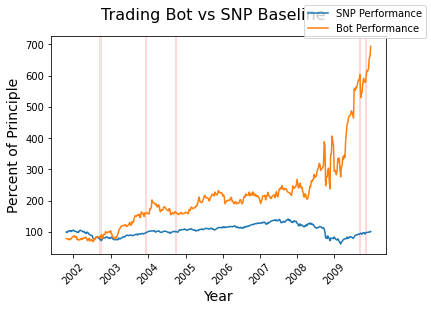

In [39]:
fig, ax = plt.subplots()
x = np.arange(len(comb))
ax.plot(x, comb['Close'], label='SNP Performance')
ax.plot(x, comb['value'], label='Bot Performance')
ax.set_xticks(years['Index'].values[1:])
ax.set_xticklabels(years['Date'].values[1:], rotation=45)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Percent of Principle', fontsize=14)

## Add the no trading regions
for i in range(len(starts)):
    ax.axvspan(starts[i], ends[i], color='red', alpha=0.1)
fig.set_size_inches(6, 4)
fig.suptitle('Trading Bot vs SNP Baseline', fontsize=16)
fig.legend()
plt.savefig(meta.results_loc + str(datetime.datetime.now()) + '.png')

## Plot the rate of change of the graph above to see if the bot is just exagerating market movement

In [40]:
window = 2
step = 1

## We start the window at the start of the series and just move it down by step
## The only complication is the date associated with the value at each window
## We can say the date used should be the midpoint of the window.

## How do we align with the graph above?
    # In addition to date as the midpoint, there will be a new column where we track the
    # Index of the date we take

ret = []
date_col = comb.columns.get_loc('Date')
close_col = comb.columns.get_loc('Close')
val_col = comb.columns.get_loc('value')
for i in range(0, len(comb) - window + 1, step):
    mid = i + window // 2
    close_slope = (comb.iloc[i+window - 1, close_col] - comb.iloc[i, close_col]) / window
    val_slope = (comb.iloc[i+window - 1, val_col] - comb.iloc[i, val_col]) / window
    ret.append((comb.iloc[mid, date_col], mid, close_slope, val_slope))
    
slope = pd.DataFrame(ret, columns=['Date', 'Index', 'Close', 'Value'])
slope['Date'] = pd.to_datetime(slope['Date']).dt.strftime('%Y').astype(int)


In [41]:
## Because the association looks pretty linear, We can fit a linear model
## To estimate the rate of change of the trading bot by the rate of change of the snp 500
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(slope['Close'].values[:, np.newaxis], slope['Value'].values)
predictions = model.predict(slope['Close'].values[:, np.newaxis])
model.intercept_, model.coef_

(0.7168975176961776, array([1.9656832]))

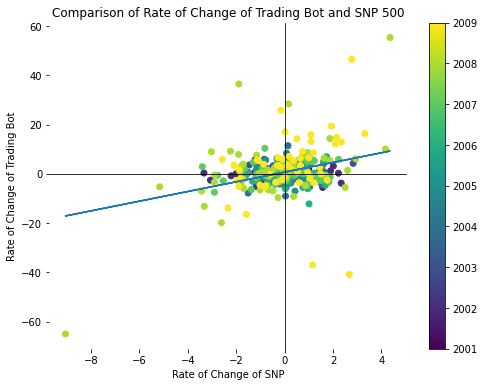

In [42]:
fig, ax = plt.subplots()
cbar = ax.scatter(slope['Close'].values, slope['Value'].values, c=slope['Date'].values)
ax.set_xlabel('Rate of Change of SNP')
ax.set_ylabel('Rate of Change of Trading Bot')

# Move the axes
ax.spines['right'].set_position('zero')
ax.spines['top'].set_position('zero')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.plot(slope['Close'].values, predictions)
ax.set_title('Comparison of Rate of Change of Trading Bot and SNP 500')
fig.set_size_inches(8, 6)
fig.colorbar(cbar, ax=ax)

## Model Performance Analysis
- I have noticed some deterioration in model performance which is what lead me to want to retrain
- This graph shows the mean sqared error over a window for the model

In [53]:
window = 60
step = 1
trades = pd.read_csv(os.path.join('..', 'data_files', 'backtest_data', 'results', 'trade_1.022_0.956_0.350.csv'))
trades['sell_date'] = pd.to_datetime(trades['sell_date'])
pred_col = trades.columns.get_loc('predicted_change')
act_col = trades.columns.get_loc('actual_change')

perf_tups = []
for i in range(0, len(trades) - window + 1, step):
    mid_dex = i + window // 2
    sell_date = trades.iloc[mid_dex, trades.columns.get_loc('sell_date')]
    pred = trades.iloc[i:i+window, pred_col]
    act = trades.iloc[i:i+window, act_col]
    mse = ((pred - act) ** 2).mean()
    hl = (((pred > 1) & (act > 1)) | ((pred < 1) & (act < 1))).mean()
    perf_tups.append((mid_dex, sell_date, mse, hl))
    
perf_df = pd.DataFrame(perf_tups, columns=['index', 'sell_date', 'mse', 'hl'])

In [54]:
perf_df.mean()


/var/folders/5w/9htyqd7s7fvcqcn47w7nfyqc0000gn/T/ipykernel_55108/2394620422.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  perf_df.mean()


index    7436.000000
mse         0.005216
hl          0.547207
dtype: float64

[Text(0, 0, '2001'),
 Text(863, 0, '2002'),
 Text(8228, 0, '2003'),
 Text(14678, 0, '2004'),
 Text(21603, 0, '2005'),
 Text(28702, 0, '2006'),
 Text(35941, 0, '2007'),
 Text(43454, 0, '2008'),
 Text(52678, 0, '2009')]

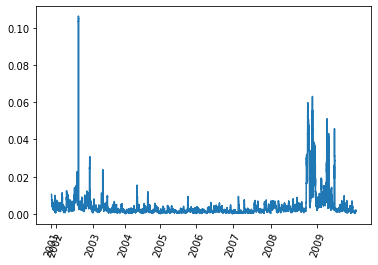

In [45]:
fig, ax = plt.subplots()
ax.plot(perf_df['index'], perf_df['mse'], label='Mean Squared Error')
dates = perf_df['sell_date'].dt.strftime('%Y').drop_duplicates()
ax.set_xticks(dates.index)
ax.set_xticklabels(dates, rotation=70)


## Trade Analysis

In [46]:
trades_df = pd.read_csv('../data_files/backtest_data/trade.csv')
trades_df

,ticker,buy_date,sell_date,num_shares,buy_price,sell_price,week_rank,position,predicted_change,actual_change
0,MU,2001-10-19 00:00:00,2001-10-26 00:00:00,481.0,20.770966,23.916569,0,buy,1.049094,1.151442
1,INTC,2001-10-19 00:00:00,2001-10-26 00:00:00,669.0,14.940689,15.998604,1,buy,1.042601,1.070808
2,FFIV,2001-10-19 00:00:00,2001-10-26 00:00:00,1296.0,7.715000,8.275000,2,buy,1.035097,1.072586
3,MCHP,2001-10-19 00:00:00,2001-10-26 00:00:00,1624.0,6.154373,6.786713,3,buy,1.034871,1.102746
4,TER,2001-10-19 00:00:00,2001-10-26 00:00:00,561.0,17.814259,22.293587,4,buy,1.033671,1.251446
...,...,...,...,...,...,...,...,...,...,...
60344,DVN,2009-12-18 00:00:00,2009-12-25 00:00:00,0.0,55.392269,58.147530,328,buy,1.001495,1.049741
60345,OKE,2009-12-18 00:00:00,2009-12-25 00:00:00,0.0,10.001631,10.298822,329,buy,1.001330,1.029714
60346,ALK,2009-12-18 00:00:00,2009-12-25 00:00:00,0.0,7.654961,8.109088,330,buy,1.001256,1.059325
60347,CVX,2009-12-18 00:00:00,2009-12-25 00:00:00,0.0,48.181316,48.513371,331,buy,1.001175,1.006892


In [47]:
(trades_df['num_shares'] * trades_df['buy_price'] * trades_df['actual_change']).sum() - (trades_df['num_shares'] * trades_df['buy_price']).sum()

337624.9936392158

In [48]:
(trades_df['actual_change'] > 1).mean()

0.5342093489535866

          COUNT
position       
buy       100.0


ValueError: x must be 1D

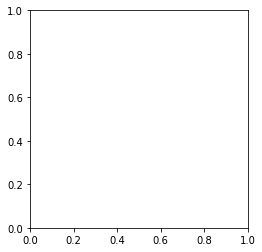

In [49]:
fig, ax = plt.subplots()
total_rows = len(trades_df)
buy_sell = trades_df.groupby('position').agg(COUNT=('position', 'count'))
buy_sell = buy_sell / total_rows * 100
print(buy_sell)
ax.pie(buy_sell.values, labels=buy_sell.index.values)